## Problem definition

Perform Text Classification on the data. The tweets have been pulled from Twitter and manual tagging has been done then.
The names and usernames have been given codes to avoid any privacy concerns.

Columns:

  1) Location

  2) Tweet At

  3) Original Tweet

based on: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

In [ ]:
! pip install demoji

## Imports

In [ ]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string

#import emoji
import demoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


###plot config
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


<ipython-input-7-2a083038f008>:46: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [ ]:
def conf_matrix(y, y_pred, title):

    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [ ]:
!ls

sample_data


## Loading datasets

In [ ]:
df_train = pd.read_csv(
    'Corona_NLP_train.csv',
    encoding='ISO-8859-1'
    )

df_test = pd.read_csv(
     'Corona_NLP_test.csv'
     )

In [ ]:
df_train.drop_duplicates(subset='OriginalTweet',inplace=True)
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df_train.OriginalTweet.iloc[0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [ ]:
df_train.OriginalTweet.iloc[1]

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

In [ ]:
df_train.OriginalTweet.iloc[2]

'Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P'

In [ ]:
df_train.shape

(41157, 6)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


## EDA of features

In [ ]:
## Transform 'TweetAt' into datetime
df_train = df_train.assign(
  dt_t0 = lambda df_: pd.to_datetime(df_['TweetAt'])
)

<ipython-input-25-b3d2f3973c8a>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dt_t0 = lambda df_: pd.to_datetime(df_['TweetAt'])


In [ ]:
df_train.dt_t0.value_counts()

2020-03-20    3448
2020-03-19    3215
2020-03-25    2979
2020-03-18    2742
2020-03-21    2653
2020-03-22    2114
2020-03-23    2062
2020-03-17    1977
2020-08-04    1881
2020-07-04    1843
2020-06-04    1742
2020-03-24    1480
2020-09-04    1471
2020-04-13    1428
2020-03-26    1277
2020-05-04    1131
2020-10-04    1005
2020-02-04     954
2020-11-04     909
2020-03-04     810
2020-12-04     803
2020-04-04     767
2020-03-16     656
2020-01-04     630
2020-03-27     345
2020-03-31     316
2020-04-14     284
2020-03-29     125
2020-03-30      87
2020-03-28      23
Name: dt_t0, dtype: int64

In [ ]:
df_train.dt_t0.min()

Timestamp('2020-01-04 00:00:00')

In [ ]:
df_train.dt_t0.max()

Timestamp('2020-12-04 00:00:00')

In [ ]:
tweets_per_day = df_train['dt_t0'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')
tweets_per_day

,index,counts
0,01-04,630
1,02-04,954
2,03-04,810
3,03-16,656
4,03-17,1977
5,03-18,2742
6,03-19,3215
7,03-20,3448
8,03-21,2653
9,03-22,2114


### Tweets per **date**

<ipython-input-30-d12ec74291b4>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tweets_per_day['index'], rotation=45, ha='right')


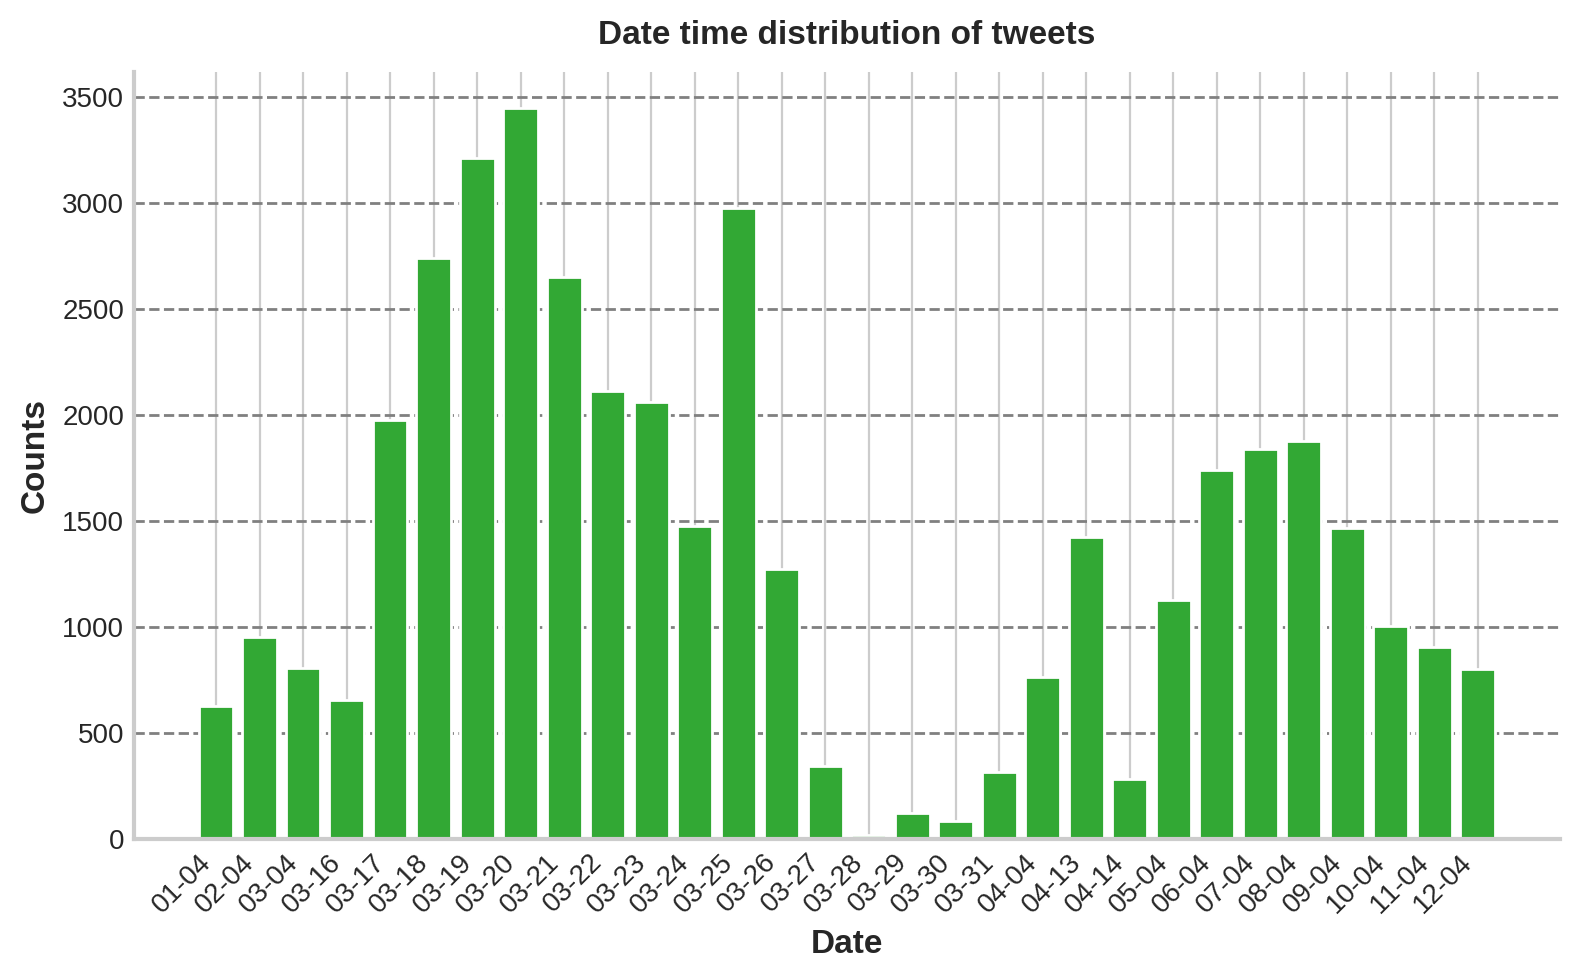

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

# Data
ax.bar(tweets_per_day['index'], tweets_per_day['counts'], color="#32a834")

# Settings
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xticklabels(tweets_per_day['index'], rotation=45, ha='right')

# Grid setting
ax.grid(which='major', axis='y', linestyle='--', color='grey', linewidth=1)

ax.set_xlabel('Date')
ax.set_ylabel('Counts')
ax.set_title('Date time distribution of tweets')
#ax.legend(title='Fruit color')

plt.show()

In [ ]:
tweets_per_country = df_train['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')
tweets_per_country

,index,counts
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


## Tweets per location

<ipython-input-32-a1c5990fa615>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tweets_per_country['index'], rotation=45, ha='right')


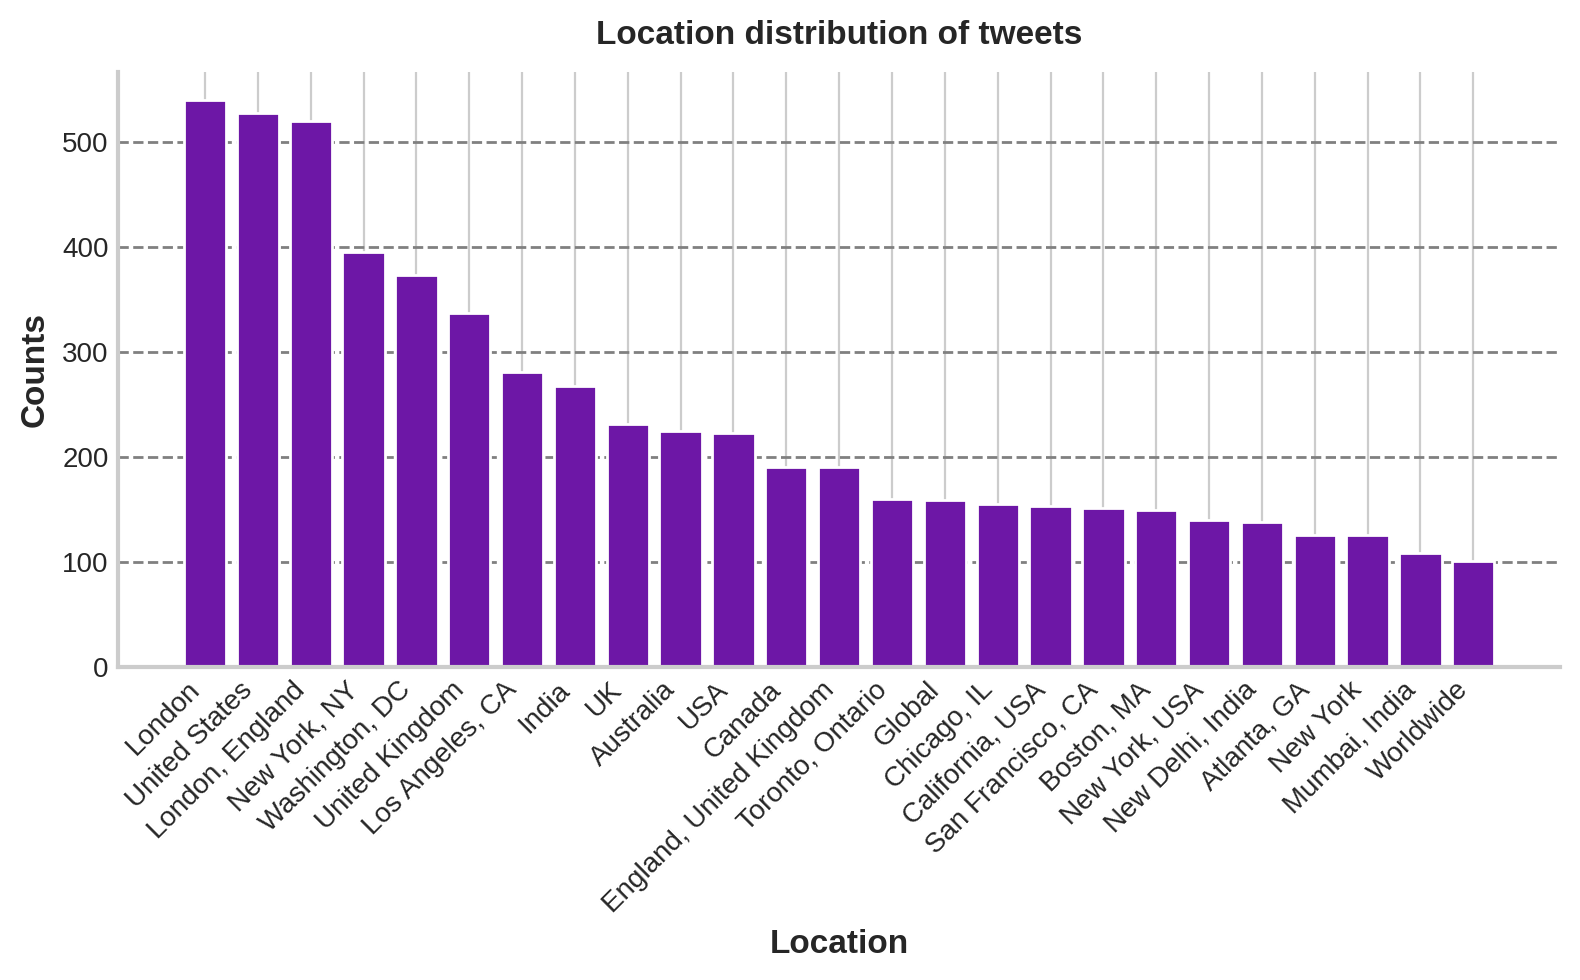

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

# Data
ax.bar(tweets_per_country['index'], tweets_per_country['counts'], color="#6d17a6") #mudar a cor

# Settings
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xticklabels(tweets_per_country['index'], rotation=45, ha='right')

# Grid setting
ax.grid(which='major', axis='y', linestyle='--', color='grey', linewidth=1)

ax.set_xlabel('Location')
ax.set_ylabel('Counts')
ax.set_title('Location distribution of tweets')

plt.show()

# Pre processing text

In [ ]:
selected_features = ['OriginalTweet','Sentiment']
df_train = df_train[selected_features]
df_test = df_test[selected_features]

## Custom Functions

In [ ]:
#Clean emojis from text
def strip_emoji(text):
    return demoji.replace(text, '')

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [ ]:
texts_new_train = []
for t in df_train.OriginalTweet:
    texts_new_train.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
df_train['text_clean'] = texts_new_train
df_test['text_clean'] = texts_new_test

In [ ]:
df_train.OriginalTweet.iloc[0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [ ]:
df_train.text_clean.iloc[0]

'and and'

In [ ]:
df_train.OriginalTweet.iloc[1]

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

In [ ]:
df_train.text_clean.iloc[1]

'advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order'

In [ ]:
df_train.OriginalTweet.iloc[3]

"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j"

In [ ]:
df_train.text_clean.iloc[3]

'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral'

Here we could see that some tweets only had mentions and links, which we could filter by size:

In [ ]:
text_len_train = []
for text in df_train.text_clean:
    tweet_len_train = len(text.split())
    text_len_train.append(tweet_len_train)

text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [ ]:
# Creating a column with the new values
df_train['text_len'] = text_len_train
df_test['text_len'] = text_len_test

In [ ]:
df_train[df_train['text_len']<10]['text_len'].value_counts()

9    593
8    420
7    312
6    224
5    137
4     94
3     65
2     25
0     25
1     13
Name: text_len, dtype: int64

In [ ]:
df_train[df_train['text_len']>10]['text_len'].value_counts().sum()

38644

In [ ]:
tweets_len = df_train[df_train['text_len']<10]['text_len'].value_counts().reset_index(name='counts')
tweets_len

,index,counts
0,9,593
1,8,420
2,7,312
3,6,224
4,5,137
5,4,94
6,3,65
7,2,25
8,0,25
9,1,13


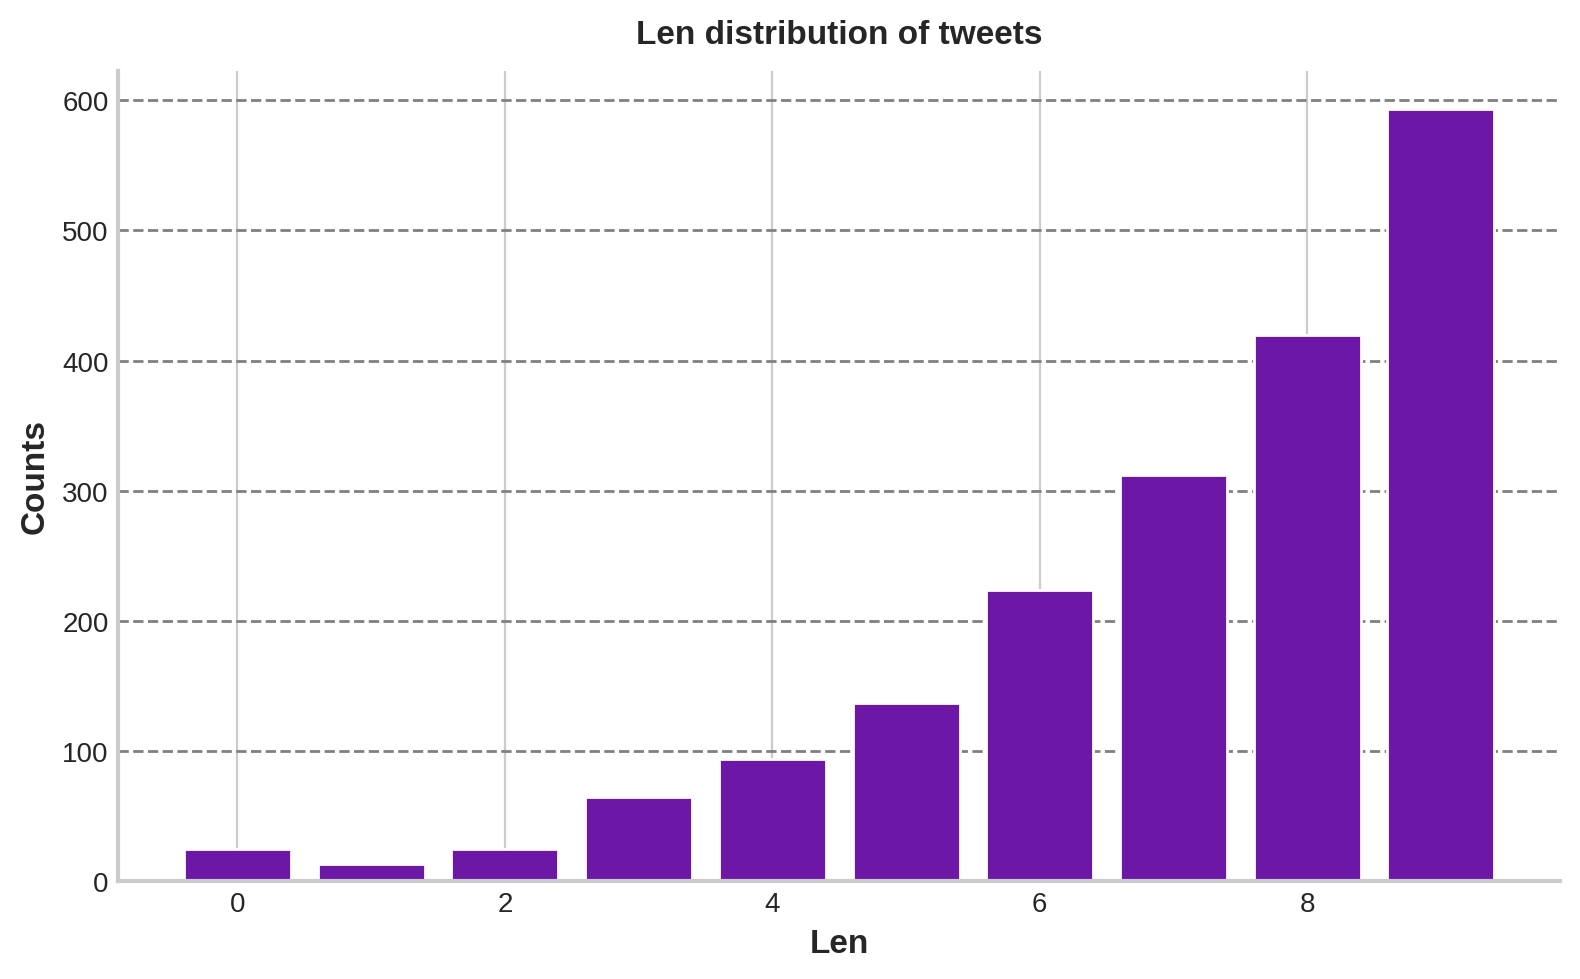

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

# Data
ax.bar(tweets_len['index'].values, tweets_len['counts'].values, color="#6d17a6")

# Settings
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
#ax.set_xticklabels(tweets_per_country['index'], rotation=45, ha='right')

# Grid setting
ax.grid(which='major', axis='y', linestyle='--', color='grey', linewidth=1)

ax.set_xlabel('Len')
ax.set_ylabel('Counts')
ax.set_title('Len distribution of tweets')

plt.show()

Here we can see that there are a few tweets with a small size, which are probably disconnected words as a result of the cleaning we've done, because of this we will only filter tweets longer than 4 words

In [ ]:
print(f" DF SHAPE: {df_train.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [ ]:
df_train = df_train[df_train['text_len'] > 4]
df_test = df_test[df_test['text_len'] > 4]

In [ ]:
print(f" DF SHAPE AFTER FILTER: {df_train.shape}")
print(f" DF TEST SHAPE AFTER FILTER: {df_test.shape}")

 DF SHAPE AFTER FILTER: (40935, 4)
 DF TEST SHAPE AFTER FILTER: (3792, 4)


## Deeper Cleaning with Bert

In [ ]:
# Using Bert Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token_lens = []
for txt in df_train['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 100


In [ ]:
token_lens = []
for i,txt in enumerate(df_train['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 1622, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 13623, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
INDEX: 16548, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
INDEX: 36953, TEXT: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

These sentences are not in english. They should be dropped.

In [ ]:
df_train['token_lens'] = token_lens
df_train = df_train.sort_values(by='token_lens', ascending=False)
df_train.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,39,80
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,37,80
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,79
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,79
18913,#CroozefmNews \r\r\nPresident Museveni has ord...,Extremely Negative,croozefmnews president museveni has ordered th...,35,79


In [ ]:
df_train = df_train.iloc[15:]
df_train.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,77
36305,Sterile disposable anti bacterial wet wipes an...,Negative,sterile disposable anti bacterial wet wipes an...,31,76
36306,For sell Sterile disposable anti bacterial wet...,Negative,for sell sterile disposable anti bacterial wet...,32,75
9238,Hi @Zomato I felt hungry loggd in ur app tryd ...,Extremely Positive,hi i felt hungry loggd in ur app tryd to add 4...,55,75
40778,#Covid_19 2days Stay-at-home activities\r\r\nU...,Neutral,covid19 2days stayathome activities up 630am f...,37,75


In [ ]:
df_train.shape

(40920, 5)

In [ ]:
df_train = df_train.sample(frac=0.2).reset_index(drop=True)


In [ ]:
df_train.shape

(8184, 5)

## Sentiment Colum Analysis

In [ ]:
df_train['Sentiment'].value_counts()

Positive              2303
Negative              1987
Neutral               1496
Extremely Positive    1349
Extremely Negative    1049
Name: Sentiment, dtype: int64

The first thing we can do is to encode the categories with numbers. We will also create just 3 possible emotions: Positive, Neutral and Negative.

In [ ]:
df_train['Sentiment'] = df_train['Sentiment'].map(
    {'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2, 'Extremely Pos':2}
    )

In [ ]:
df_test['Sentiment'] = df_test['Sentiment'].map(
    {'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2}
    )

In [ ]:
df_train['Sentiment'].value_counts()

2    3652
0    3036
1    1496
Name: Sentiment, dtype: int64

In [ ]:
df_test['Sentiment'].value_counts()

0    1632
2    1545
1     615
Name: Sentiment, dtype: int64

We note that the three classes are imbalanced. We will proceed with oversampling the train test, to remove bias towards the majority classes.

## Class Balancing by RandomOverSampler

In [ ]:
np.array(df_train['text_clean']).reshape(-1, 1)

array([['people think its bizarre ironic and funny when a frozen meat company points out the importance of critical thinking but chances are the same message would never go viral if it was from a person our society values entertainment over truth and thats a huge problem'],
       ['two workers at safeway near by and tested positive for covid19 take care friends and colleagues stay safe'],
       ['grocery store hours for seniors now includes northgate gonzalez markets vallarta supermarkets super a foods and big saver foods seniors coronavirus'],
       ...,
       ['i would like to say a genuine heartfelt thank you to all of our nhs workers supermarket workers and everyone else who has gone above and beyond the call of duty during these difficult times be kind to one another always 19'],
       ['i went to the grocery store this afternoon they are pretty picked over and limiting what one can buy the good news is that you can buy as many butter bunnies as you want i brought one home ju

In [ ]:
ros = RandomOverSampler()

train_x, train_y = ros.fit_resample(
    np.array(df_train['text_clean']).reshape(-1, 1),
    np.array(df_train['Sentiment']).reshape(-1, 1)
  )

train_x

array([['people think its bizarre ironic and funny when a frozen meat company points out the importance of critical thinking but chances are the same message would never go viral if it was from a person our society values entertainment over truth and thats a huge problem'],
       ['two workers at safeway near by and tested positive for covid19 take care friends and colleagues stay safe'],
       ['grocery store hours for seniors now includes northgate gonzalez markets vallarta supermarkets super a foods and big saver foods seniors coronavirus'],
       ...,
       ['read 5 tips from a consumer psychologist on how brands should respond to coronavirus how many of these tactics do you have in place'],
       ['check out new piece as with 911 and other seismic cultural events the covid19 pandemic of 2020 will be forever etched in our collective brains as a marker of change coronavirus'],
       ['cant make this up only crate of alcohol on the shelf in the supermarket']],
      dtype=objec

In [ ]:
train_x[0]

array(['people think its bizarre ironic and funny when a frozen meat company points out the importance of critical thinking but chances are the same message would never go viral if it was from a person our society values entertainment over truth and thats a huge problem'],
      dtype=object)

In [ ]:
train_os = pd.DataFrame(
    list(zip([x[0] for x in train_x], train_y)),
    columns = ['text_clean', 'Sentiment']
    )
train_os

,text_clean,Sentiment
0,people think its bizarre ironic and funny when...,2
1,two workers at safeway near by and tested posi...,2
2,grocery store hours for seniors now includes n...,2
3,with oil prices falling amid the covid19 reces...,0
4,the prices of lemon and ginger are going up wh...,0
...,...,...
10951,tpmelection new york s food pantries face an u...,1
10952,always wanted to learn british signlanguage du...,1
10953,read 5 tips from a consumer psychologist on ho...,1
10954,check out new piece as with 911 and other seis...,1


In [ ]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [ ]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

### One Hot Enconding

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 9860
VALIDATION DATA: 1096
TESTING DATA: 3792


# Baseline Model: Naive Bayes

In [ ]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Here we use the tfidf transform as a feature for our baseline model

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)

X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [ ]:
X_train_tf[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
len(X_train_tf[0].toarray().reshape(-1,1))

19275

In [ ]:
[x for x in X_train_tf[0].toarray().reshape(-1,1) if x!=0]

[array([0.4122821]),
 array([0.23123433]),
 array([0.0837907]),
 array([0.0888779]),
 array([0.19570643]),
 array([0.16224754]),
 array([0.37350265]),
 array([0.23780486]),
 array([0.2743134]),
 array([0.43065657]),
 array([0.43065657]),
 array([0.07213059]),
 array([0.22264886])]

## Model

In [ ]:
nb_clf = MultinomialNB()

nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [ ]:
nb_pred = nb_clf.predict(X_test_tf)

In [ ]:
print(
    '\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive'])
    )

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.68      0.76      0.71      1632
     Neutral       0.57      0.36      0.44       615
    Positive       0.69      0.71      0.70      1545

    accuracy                           0.67      3792
   macro avg       0.65      0.61      0.62      3792
weighted avg       0.67      0.67      0.67      3792



# BERT

In [ ]:
MAX_LEN=128

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

## Model

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):

    ##params###
    # define optimizer
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)

    # define loss
    loss = tf.keras.losses.CategoricalCrossentropy()

    # evaluate model accuracy
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # define model entry
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    # separate embeddings
    embeddings = bert_model([input_ids,attention_masks])[1]

    # create a new layer for class prediction
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    # compiles the model
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)

    return model

In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [ ]:
history_bert = model.fit(
    [train_input_ids,train_attention_masks],
    y_train,
    validation_data=([val_input_ids,val_attention_masks], y_valid),
    epochs=1,
    batch_size=42
                         )

235/235 [==============================] - 12523s 53s/step - loss: 0.8566 - categorical_accuracy: 0.6019 - val_loss: 0.6507 - val_categorical_accuracy: 0.7226


In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

119/119 [==============================] - 1600s 13s/step


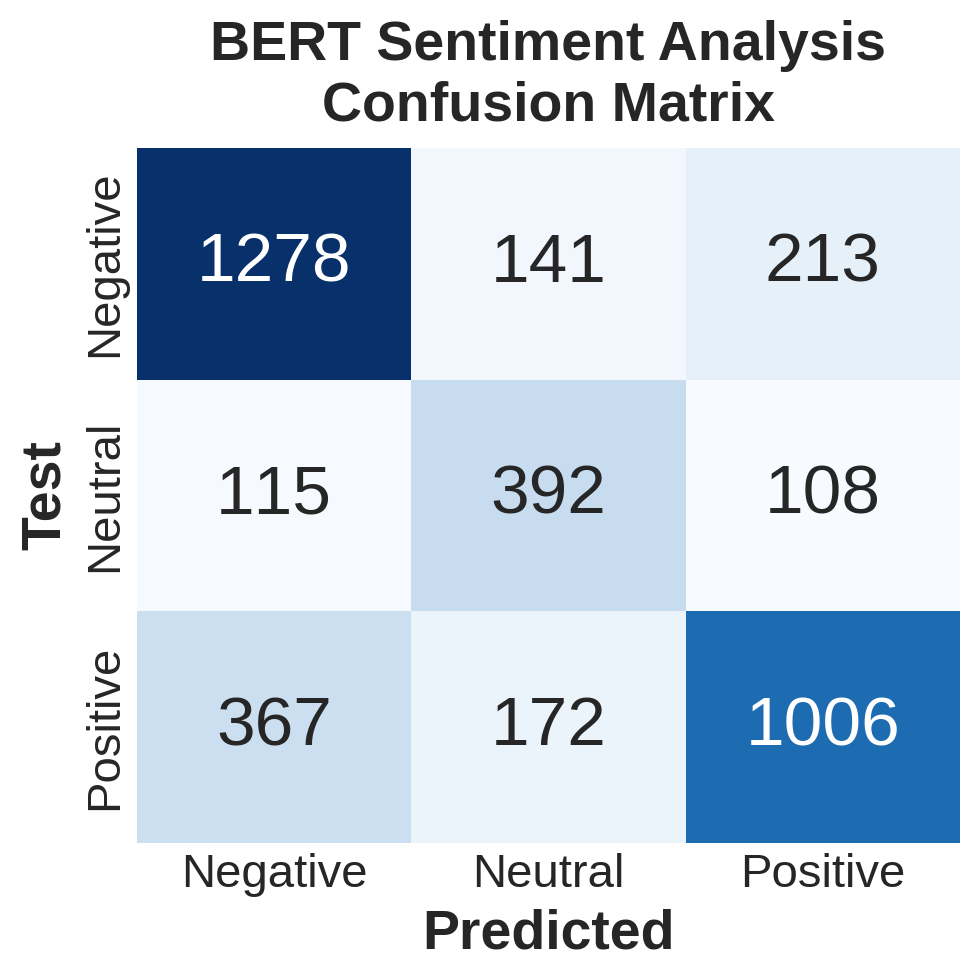

In [ ]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.73      0.78      0.75      1632
     Neutral       0.56      0.64      0.59       615
    Positive       0.76      0.65      0.70      1545

   micro avg       0.71      0.71      0.71      3792
   macro avg       0.68      0.69      0.68      3792
weighted avg       0.71      0.71      0.71      3792
 samples avg       0.71      0.71      0.71      3792

